In [1]:
%matplotlib inline

## [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)
- PCA decomposes a multivariate dataset into successive orthogonal *components* that explain a maximum amount of variance.
- PCA centers, but does not scale, the dataset for each feature before applying SVD.

## Comparison, LDA vs PCA, 2D projection of Iris dataset
- PCA identifies which attributes account for the most variance. Below: samples plotted on the 1st two principle components.
- LDA identifies which attributes account for the most variance *between classes*. LDA is a supervised method & uses known class labels.

In [2]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()
X, y, labels = iris.data, iris.target, iris.target_names

pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)

X_r  = pca.fit(X).transform(X)
X_r2 = lda.fit(X, y).transform(X)

In [3]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.92461872 0.05306648]


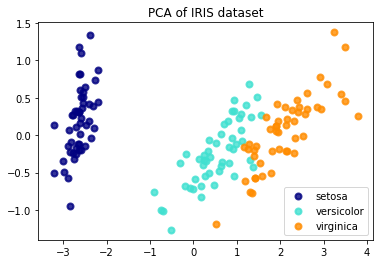

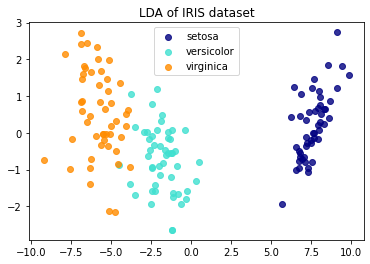

In [5]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], labels):
    plt.scatter(X_r[y == i, 0], 
                X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], labels):
    plt.scatter(X_r2[y == i, 0], 
                X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

## [Incremental PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA)
- Std PCA only supports batch processing (all data to be processed must fit in main memory). Incremental PCA sidesteps this limitation by allowing partial computations (minibatching).
- Incremental PCA enables out-of-core PCA by
    - 1) using ```partial_fit``` on data chunks fetched sequentially from disk or the network
    - 2) calling ```fit``` on a sparse matrix, or a memory mapped file.
- Incremental PCA only stores *estimates* of component & noise variables. Memory usage depends on the #samples/batch, not the #samples to be processed in the dataset.
- Incremental PCA centers, but does not scale, input data for each feature before applying the SVD.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

iris = load_iris()
X, y = iris.data, iris.target
n_components = 2
pca =             PCA(n_components=n_components)
ipca = IncrementalPCA(n_components=n_components, batch_size=10)

X_pca = pca.fit_transform(X)
X_ipca = ipca.fit_transform(X)

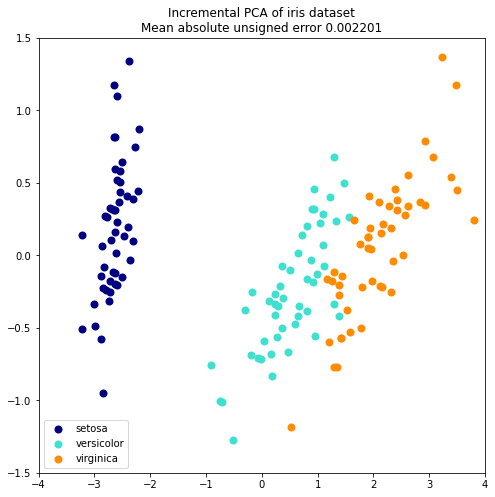

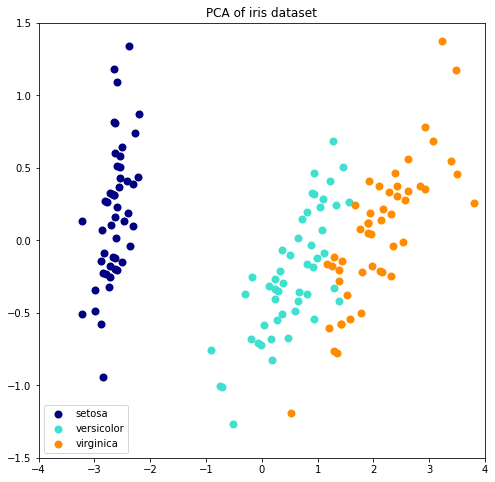

In [11]:
colors = ['navy', 'turquoise', 'darkorange']

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, 
                                     [0, 1, 2], 
                                     iris.target_names):
        plt.scatter(X_transformed[y == i, 0], 
                    X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

## PCA using randomized SVD
- Useful when you want to project data to a lower-D space that preserves most of the variance - by dropping the singular components vector of lower singular values.
- Done with PCA param ```svd_solver='randomized'```.
- Example: working with 64x64 px gray-level pictures (dimensionality = 4096) - it makes sense to reduce the dimensions down because of human face similarities.

In [12]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [13]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components = n_components, 
          svd_solver   = 'randomized',
          whiten       = True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 0.367s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s


In [15]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 30.333s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [16]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.051s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.90      0.72      0.79       322
     weighted avg       0.86      0.85      0.84       322

[[  7   1   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  0   3  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   3   1   7   0]
 [  0   2   1   5   0   0  28]]


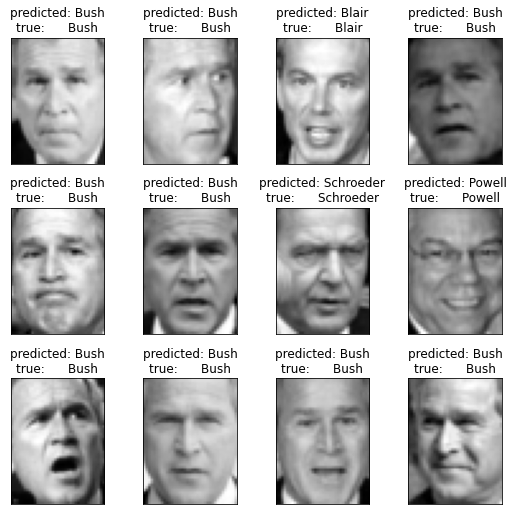

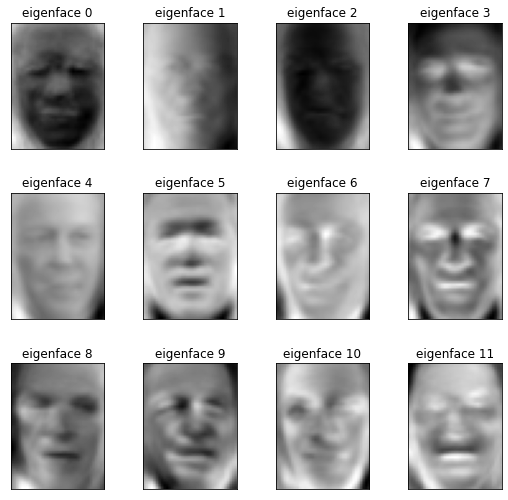

In [17]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## [Kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA)
- extends PCA to non-linear dimensionality reduction by using a [kernel](https://scikit-learn.org/stable/modules/metrics.html#metrics).

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples = 400, 
                    factor    = 0.3, 
                    noise     = 0.05)

kpca = KernelPCA(kernel="rbf", 
                 fit_inverse_transform=True, 
                 gamma=10)

X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)

pca = PCA(); X_pca = pca.fit_transform(X)

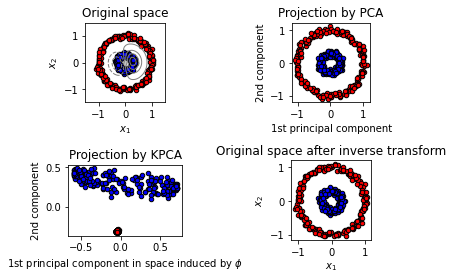

In [21]:
plt.figure()
reds = y == 0; blues = y == 1
plt.subplot(2, 2, 1, aspect='equal')

plt.title("Original space")
plt.scatter(X[reds, 0], 
            X[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X[blues, 0], 
            X[blues, 1], c="blue", s=20, edgecolor='k')

plt.xlabel("$x_1$"); plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), 
                     np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), 
                   np.ravel(X2)]).T

# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)

plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')


plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], 
            X_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], 
            X_pca[blues, 1], c="blue", s=20, edgecolor='k')

plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")


plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], 
            X_kpca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], 
            X_kpca[blues, 1], c="blue", s=20, edgecolor='k')

plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")


plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], 
            X_back[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], 
            X_back[blues, 1], c="blue", s=20, edgecolor='k')

plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

## [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA)
- PCA's extracted components are extremely dense (non-zero coefficients expressed as linear combinations of the original variables), which can be difficult to interpret.
- Sparse PCA's principal components are easier to interpret.